## Import Packages

In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon

from utils_file.tools import load_cache_file
from utils_file.finance_tools import *

warnings.filterwarnings("ignore")
path = "figure_file"

## Load Data

In [2]:
# static_pairs = load_cache_file("data_file/static_strategy/ap_reward_result_test.pkl")
static_pairs = load_cache_file("data/ap_reward_result_test.pkl")

## Comparison Target: Reduced S&P500 Constituent

In [3]:
test_data = pd.read_csv("data/test.csv", encoding="UTF-8")
tickers = test_data["Ticker"].unique()

In [4]:
# Add daily log return and Bollinger bands to the original stock price data
append_value = []

for ticker in tickers:
    target = test_data[test_data["Ticker"] == ticker].copy()
    target["ma_line"] = target["Close"].rolling(window=5).mean()
    std = target["Close"].rolling(window=5).std()
    target["upper_bound"] = target["ma_line"] + 1 * std
    target["lower_bound"] = target["ma_line"] - 1 * std

    target["log_return"] = np.log(target["Close"] / target["Close"].shift(1))

    target = target.dropna()
    append_value.append(target)

test_append = pd.concat(append_value, ignore_index=True)

In [5]:
# Divide the stock price data of individual stocks according to each month
split_test = {}

unique_years = test_append["Year"].unique()
unique_months = test_append["Month"].unique()

idx = 1
for year in unique_years:
    for month in unique_months:
        split_test[f"state_{idx}"] = {}
        mask_table = test_append[(test_append["Year"] == year) & (test_append["Month"] == month)]

        for ticker in tickers:
            split_test[f"state_{idx}"][ticker] = mask_table[mask_table["Ticker"] == ticker].copy()
        
        idx += 1

## Strategy: Buy and Hold

In [6]:
single_result_BandH = {}

for state in list(split_test.keys()):
    all_ticker_reward = []

    for ticker in tickers:
        all_ticker_reward.append(split_test[state][ticker]["log_return"].sum())
    
    single_result_BandH[state] = all_ticker_reward

In [7]:
single_result_BandH_table = pd.DataFrame(single_result_BandH, index=tickers)

static_pairs_table = pd.DataFrame(static_pairs).T

## Strategy: Bollinger Bands

In [8]:
# Each component stock executes a Bollinger Band trading strategy
single_result_BB = {}

for state in list(split_test.keys()):
    all_ticker_reward = []

    for ticker in tickers:
        temp = split_test[state][ticker]

        ub_open_flag = False
        lb_open_flag = False
        status_list = []

        for i, row in temp.iterrows():
            if row["Close"] > row["upper_bound"] and ub_open_flag is False:
                status_list.append("UB_open")
                ub_open_flag = True

            elif row["Close"] < row["ma_line"] and ub_open_flag is True:
                status_list.append("UB_close")
                ub_open_flag = False

            elif row["Close"] < row["lower_bound"] and lb_open_flag is False:
                status_list.append("LB_open")
                lb_open_flag = True

            elif row["Close"] > row["ma_line"] and lb_open_flag is True:
                status_list.append("LB_close")
                lb_open_flag = False

            else:
                status_list.append(0)

        status_list[-1] = "close"
        temp["status"] = status_list

        reward_record = []
        UB_price = None
        LB_price = None

        for i, row in temp.iterrows():
            if row["status"] == "UB_open" and UB_price is None:
                UB_price = row["Close"]

            elif row["status"] == "LB_open" and LB_price is None:
                LB_price = row["Close"]

            elif row["status"] == "UB_close" and UB_price is not None:
                simple_return = (row["Close"] - UB_price) / UB_price
                reward_record.append(simple_return)
                UB_price = None

            elif row["status"] == "LB_close" and LB_price is not None:
                simple_return = -(row["Close"] - LB_price) / LB_price
                reward_record.append(simple_return)
                LB_price = None

            elif row["status"] == "close" and UB_price is not None:
                simple_return = (row["Close"] - UB_price) / UB_price
                reward_record.append(simple_return)

            elif row["status"] == "close" and LB_price is not None:
                simple_return = -(row["Close"] - LB_price) / LB_price
                reward_record.append(simple_return)

        all_ticker_reward.append(sum(reward_record))

    single_result_BB[state] = all_ticker_reward

In [9]:
single_result_BB_table = pd.DataFrame(single_result_BB, index=tickers)

## Boxplot for rewards

In [10]:
single_result_BandH_table.columns = static_pairs_table.columns  # adjust the column name

plot_data_merge = pd.concat([static_pairs_table, single_result_BandH_table], axis=0)
plot_data_merge["type"] = ["Static PT"] * len(static_pairs_table) + ["Single Assets"] * len(single_result_BandH_table)

plot_data_merge = plot_data_merge.melt(id_vars="type", var_name="time", value_name="value")
plot_data_merge["time"] = plot_data_merge["time"] + 1

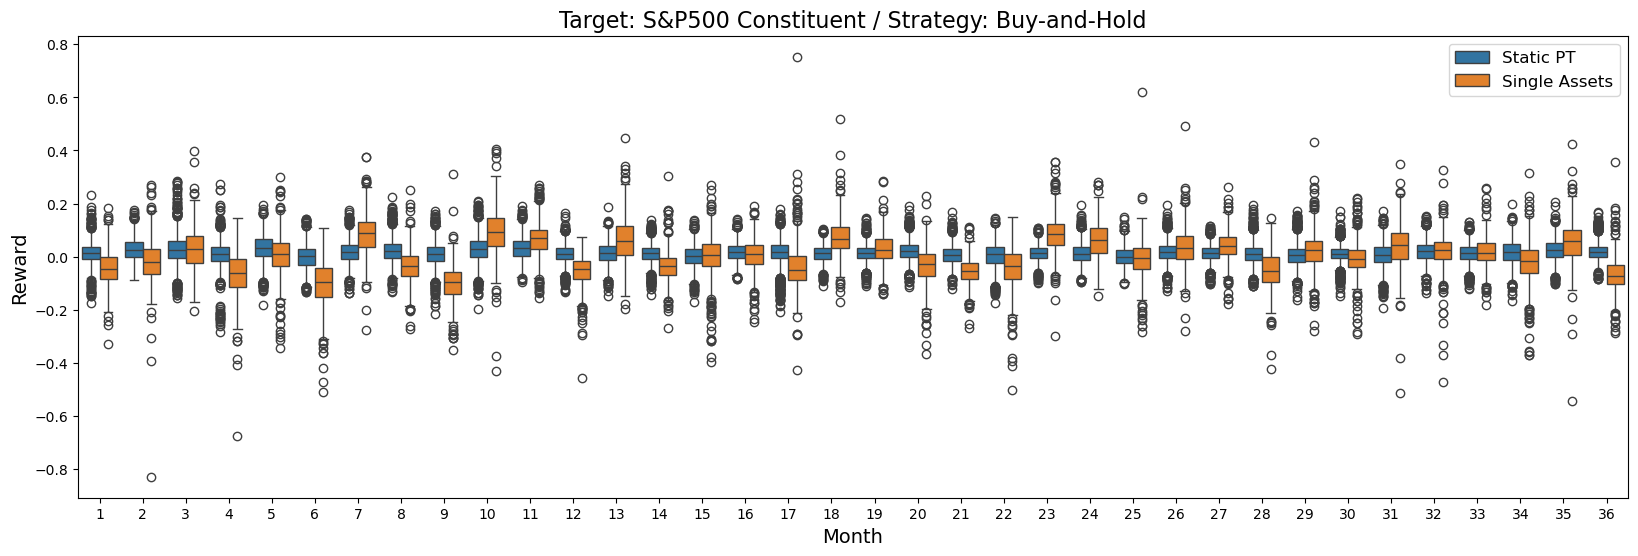

In [12]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=plot_data_merge, x="time", y="value", hue="type")
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: S&P500 Constituent / Strategy: Buy-and-Hold", fontsize=16)
# plt.savefig(f"{path}/singleAsset_vs_staticPT_BandH.png", dpi=300, bbox_inches="tight")
plt.show()

In [13]:
single_result_BB_table.columns = static_pairs_table.columns  # adjust the column name

plot_data_merge_BB = pd.concat([static_pairs_table, single_result_BB_table], axis=0)
plot_data_merge_BB["type"] = ["Static PT"] * len(static_pairs_table) + ["Single Assets"] * len(single_result_BB_table)

plot_data_merge_BB = plot_data_merge_BB.melt(id_vars="type", var_name="time", value_name="value")
plot_data_merge_BB["time"] = plot_data_merge_BB["time"] + 1

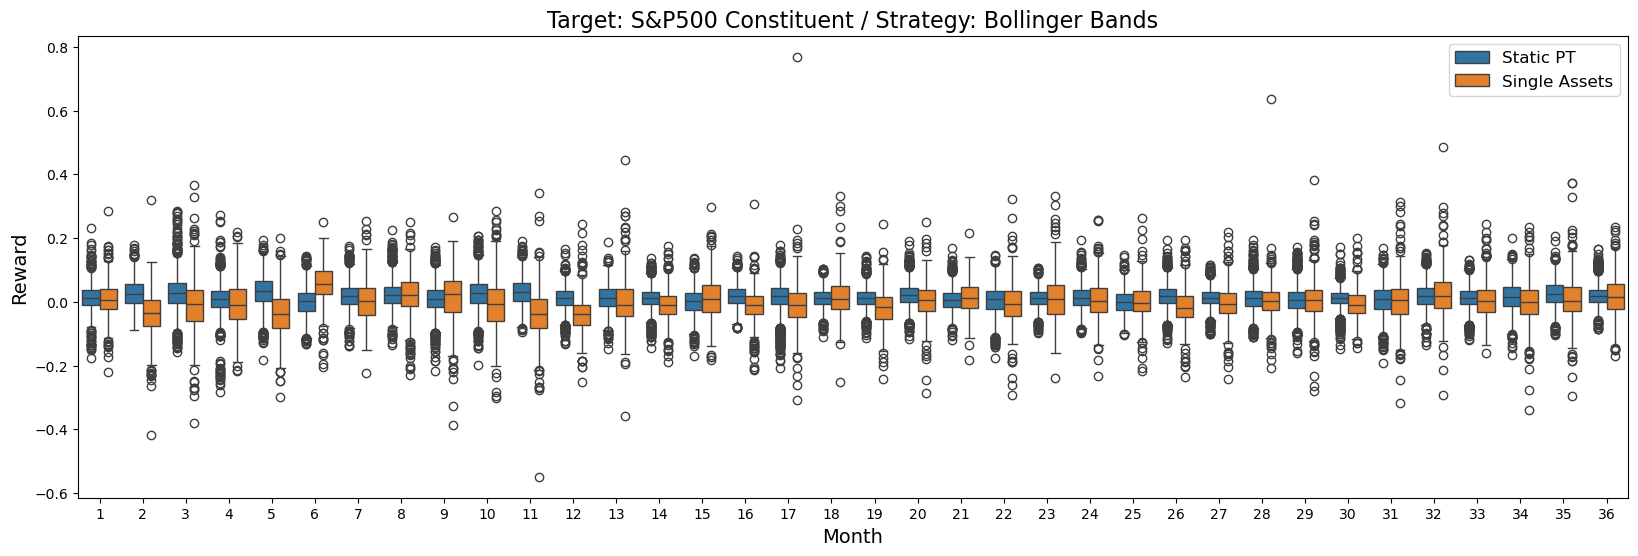

In [14]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=plot_data_merge_BB, x="time", y="value", hue="type")
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: S&P500 Constituent / Strategy: Bollinger Bands", fontsize=16)
# plt.savefig(f"{path}/singleAsset_vs_staticPT_BB.png", dpi=300, bbox_inches="tight")
plt.show()

## WRS test for median

In [15]:
static_pairs_median = static_pairs_table.median(axis=0)
single_median_BandH = single_result_BandH_table.median(axis=0)

statistic, pvalue = wilcoxon(static_pairs_median, single_median_BandH, alternative="greater")
print(f"p-value of WRS test: {pvalue: .4e}")

p-value of WRS test:  9.0706e-02


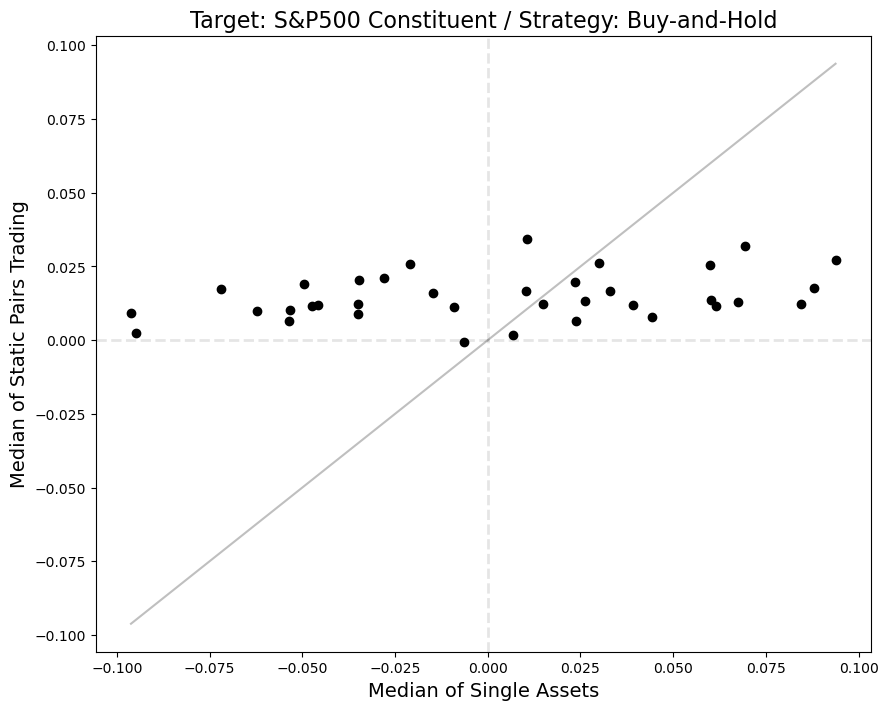

In [16]:
plt.figure(figsize=(10, 8))
plt.scatter(single_median_BandH, static_pairs_median, color="black")
plt.plot(
    np.linspace(
        min(min(single_median_BandH), min(static_pairs_median)), 
        max(max(single_median_BandH), max(static_pairs_median)), 
        200
    ),
    np.linspace(
        min(min(single_median_BandH), min(static_pairs_median)), 
        max(max(single_median_BandH), max(static_pairs_median)), 
        200
    ),
    color="grey", alpha=0.5 
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Single Assets", fontsize=14)
plt.ylabel("Median of Static Pairs Trading", fontsize=14)
plt.title("Target: S&P500 Constituent / Strategy: Buy-and-Hold", fontsize=16)
# plt.savefig(f"{path}/singleAsset_vs_staticPT_BandH_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

In [17]:
single_median_BB = single_result_BB_table.median(axis=0)

statistic, pvalue = wilcoxon(static_pairs_median, single_median_BB, alternative="greater")
print(f"p-value of WRS test: {pvalue: .4e}")

p-value of WRS test:  7.3048e-06


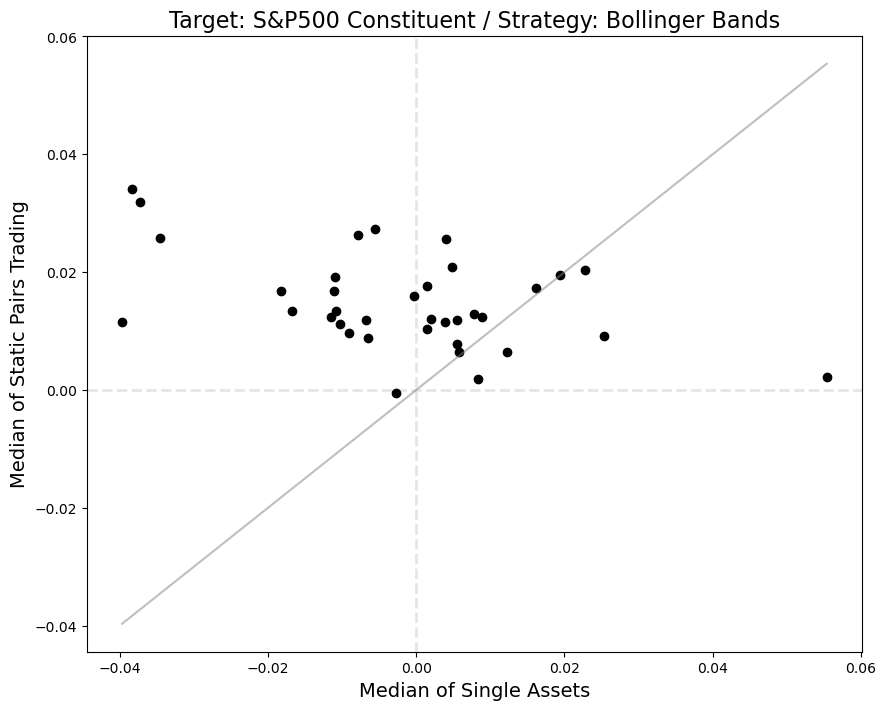

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(single_median_BB, static_pairs_median, color="black")
plt.plot(
    np.linspace(
        min(min(single_median_BB), min(static_pairs_median)), 
        max(max(single_median_BB), max(static_pairs_median)), 
        200
    ),
    np.linspace(
        min(min(single_median_BB), min(static_pairs_median)), 
        max(max(single_median_BB), max(static_pairs_median)), 
        200
    ),
    color="grey", alpha=0.5 
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Single Assets", fontsize=14)
plt.ylabel("Median of Static Pairs Trading", fontsize=14)
plt.title("Target: S&P500 Constituent / Strategy: Bollinger Bands", fontsize=16)
# plt.savefig(f"{path}/singleAsset_vs_staticPT_BB_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

## Cumulative Reward Plot

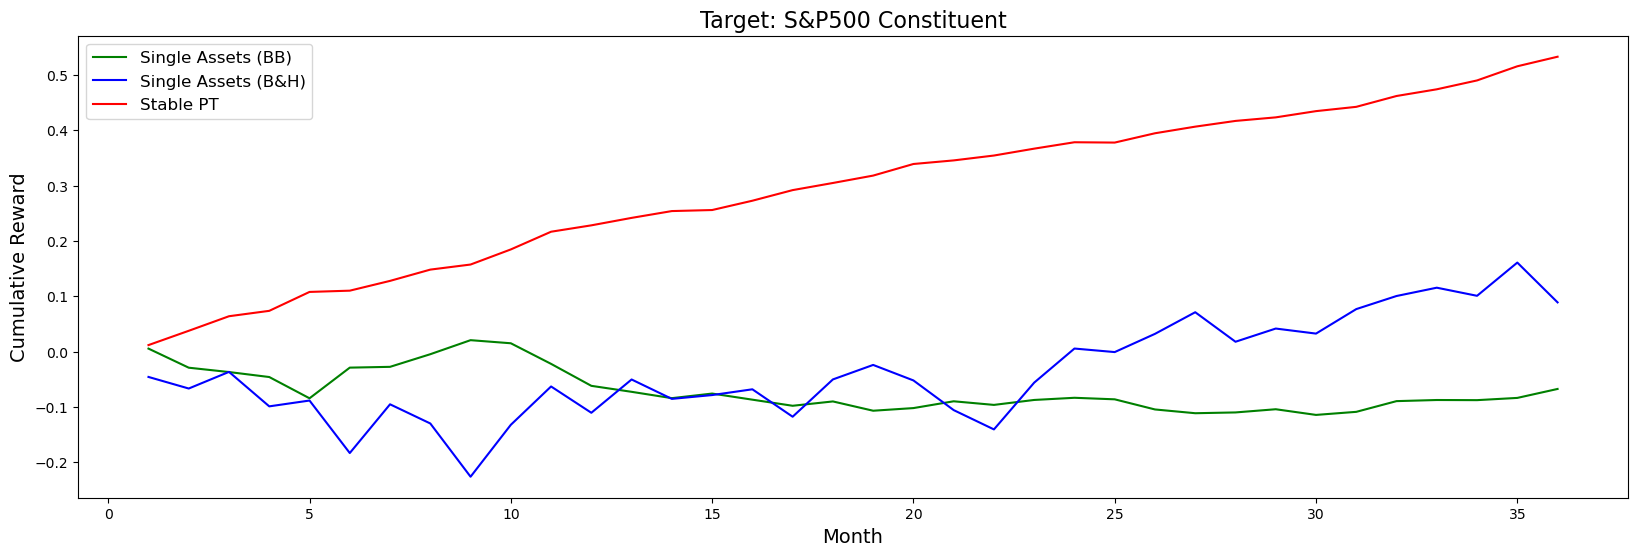

In [19]:
plt.figure(figsize=(20, 6))
plt.plot(range(1, 37), single_median_BB.cumsum(), color="green", label="Single Assets (BB)")
plt.plot(range(1, 37), single_median_BandH.cumsum(), color="blue", label="Single Assets (B&H)")
plt.plot(range(1, 37), static_pairs_median.cumsum(), color="red", label="Stable PT")
plt.xlabel("Month", fontsize=14)
plt.ylabel("Cumulative Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: S&P500 Constituent", fontsize=16)
plt.show()

## Performance Indicators

In [20]:
print(f"Mean Return: {mean_return(static_pairs_median) * 100: .2f}")
print(f"Sharpe Ratio: {sharpe_ratio(static_pairs_median): .2f}")
print(f"Sortino Ratio: {sortino_ratio(static_pairs_median): .2f}")
print(f"Profit Factor: {profit_factor(static_pairs_median): .2f}")
print(f"Calmar Ratio: {calmar_ratio(static_pairs_median): .2f}")
print(f"Max Drawdown: {max_drawdown(static_pairs_median): .2f}")

Mean Return:  17.76
Sharpe Ratio:  6.45
Sortino Ratio:  17.76
Profit Factor:  912.15
Calmar Ratio:  303.72
Max Drawdown: -0.00


In [21]:
print(f"Mean Return: {mean_return(single_median_BB) * 100: .2f}")
print(f"Sharpe Ratio: {sharpe_ratio(single_median_BB): .2f}")
print(f"Sortino Ratio: {sortino_ratio(single_median_BB): .2f}")
print(f"Profit Factor: {profit_factor(single_median_BB): .2f}")
print(f"Calmar Ratio: {calmar_ratio(single_median_BB): .2f}")
print(f"Max Drawdown: {max_drawdown(single_median_BB): .2f}")

Mean Return: -2.25
Sharpe Ratio: -0.35
Sortino Ratio: -0.52
Profit Factor:  0.76
Calmar Ratio: -0.17
Max Drawdown: -0.13


In [22]:
print(f"Mean Return: {mean_return(single_median_BandH) * 100: .2f}")
print(f"Sharpe Ratio: {sharpe_ratio(single_median_BandH): .2f}")
print(f"Sortino Ratio: {sortino_ratio(single_median_BandH): .2f}")
print(f"Profit Factor: {profit_factor(single_median_BandH): .2f}")
print(f"Calmar Ratio: {calmar_ratio(single_median_BandH): .2f}")
print(f"Max Drawdown: {max_drawdown(single_median_BandH): .2f}")

Mean Return:  2.97
Sharpe Ratio:  0.17
Sortino Ratio:  0.33
Profit Factor:  1.12
Calmar Ratio:  0.16
Max Drawdown: -0.19
